The code to generate all of the figure panels for Figure 3

## Imports

In [1]:

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import scanpy as sc
from anndata import AnnData, concat

import matplotlib.pyplot as plt
import matplotlib_venn as venn
import seaborn as sns

from scipy import sparse, stats
from scipy.cluster import hierarchy
import pymn
import gc
from upsetplot import plot as UpSet
from itertools import product
import networkx as nx


import re
import h5py

import itertools

import statsmodels.api as sm

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

from pathlib import Path

In [3]:
%matplotlib inline

In [4]:
#These save characters as text in PDFs
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#These change plot aesthetics

sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)

In [5]:
sc.settings.verbosity = 3

In [6]:
import sys
sys.path.append('/home/bharris/pseudotime/scripts/')
from mn_utils import *

In [7]:
from move_seaborn_legend import move_legend
from egad import run_egad
import enrichment_stats

In [8]:
import mkl


mkl.set_num_threads(8)

48

## Functions

In [832]:
def order_rows_according_to_cols(M, alpha=1.0):
    """Helper function for clustering rows
    Cluster rows to make high values along the diagonal
    Arguments:
    M {pd.DataFrame} -- Dataframe with columns order how they will be plotted
    Keyword Arguments:
    alpha {number} -- Power to raise dataframe to, higher gives more weight to extreme values (default: {1})
    Returns:
    np.ndarray -- 1-D array with order for rows
    """
    M2 = M.values**alpha
    row_score = np.nansum(M2.T * np.arange(M2.shape[1])[:, None],
                          axis=0) / np.nansum(M2, axis=1)
    return M.index[np.argsort(row_score)]
def getDotPlotData(adata,
                gene_set,
                normalize_library_size=True,
                mn_key="MetaNeighbor",
                study_col=None,
                ct_col=None,
                alpha_row=10,
                average_expressing_only=True,
                figsize=(10, 6),
                fontsize=10,
                show=True,
                **kwargs):
    """Plot dot plot showing expression of a gene set across cell types.
    The size of each dot reflects the number of cell that express a gene,
    the color reflects the average expression.
    Expression of genes is first average and scaled in each dataset
    independently. The final value is obtained by averaging across datasets.
    Arguments:
        adata {AnnData} -- AnnData object containing expression and metadata
        gene_set {pd.Series} -- Boolean pd.Series with genes as index and Genes that are in the geneset as True
    Keyword Arguments:
        normalize_library_size {bool} -- Wheter to normalize cells by library size (default: {True})
        mn_key {str} -- Locatoin of MetaNeighborUS results to get params data (default: {'MetaNeighbor'})
        study_col {vector} -- If none, inferrefed from adata.uns[f'{mn_key}_params']['study_col'],
            else vector of study ids (default: {None})
        ct_col {vector} -- If none, inferrefed from adata.uns[f'{mn_key}_params']['ct_col'],
            else vector of cell type labels (default: {None})
        alpha_row {number} -- Parameter controling row ordering: a higher value of
            alpha_row gives more weight to extreme AUROC values (close to 1) (default: {10})
        average_expressing_only {bool} -- Whether average expression should be computed based
            only on expressing cells (Seurat default) or taking into account zeros (default: {True})
        figsize {tuple} -- Tuple that sets figure size in inches (default: {(10,6)})
        fontsize {number} -- Fontsize of gene names in y axis ticks (default: {10})
        show {bool} -- If True shows plot, else returns ax (default: {True})
    """
    if study_col is None:
        study_col = adata.uns[f"{mn_key}_params"]["study_col"]
    else:
        assert study_col in adata.obs_keys(), "Must pass study col in obs keys"
    if ct_col is None:
        ct_col = adata.uns[f"{mn_key}_params"]["ct_col"]
    else:
        assert ct_col in adata.obs_keys(), "Must pass ct col in obs keys"

    gs = gene_set.index[gene_set.astype(bool)]
    gs = np.intersect1d(gs, adata.var_names)

    if normalize_library_size:
        expr = adata[:, gs].to_df().T
        expr /= np.ravel(adata.X.sum(axis=1)) * 1e6

    else:
        expr = adata[:, gs].to_df().T

    label_matrix = pymn.utils.design_matrix(
        pymn.utils.join_labels(adata.obs[study_col].values, adata.obs[ct_col].values))
    label_matrix /= label_matrix.sum()
    centroids = pd.DataFrame(
        expr.fillna(0).values.astype(float)
        @ label_matrix.values.astype(float),
        index=expr.index,
        columns=label_matrix.columns,
    )
    average_nnz = pd.DataFrame(
        ((expr.fillna(0).values > 0).astype(float) @ label_matrix.values),
        index=expr.index,
        columns=label_matrix.columns,
    )
    if average_expressing_only:
        centroids /= average_nnz
    centroids = centroids.T.astype(float).apply(stats.zscore,
                                                nan_policy='omit').T
    centroids.index.name = "Gene"
    average_nnz.index.name = "Gene"

    centroids.reset_index(inplace=True)
    average_nnz.reset_index(inplace=True)

    pheno, _, _ = pymn.utils.create_cell_labels(adata, study_col, ct_col)
    pheno.set_index("study_ct", inplace=True)
    pheno2 = pheno.drop_duplicates()

    centroids = pd.melt(centroids,
                        id_vars="Gene",
                        value_name="Average Expression",
                        var_name="study_ct")
    centroids.loc[:, "Cell Type"] = pheno2.loc[centroids["study_ct"].
                                               values, ct_col].values
    centroids = centroids.groupby(["Gene", "Cell Type"]).agg({
        'Average Expression':
        lambda x: x.mean(skipna=False)
    }).reset_index()

    average_nnz = pd.melt(
        average_nnz,
        id_vars="Gene",
        value_name="Percent Expressing",
        var_name="study_ct",
    )
    average_nnz.loc[:, "Cell Type"] = pheno2.loc[average_nnz["study_ct"].
                                                 values, ct_col].values

    average_nnz = average_nnz.groupby(["Gene",
                                       "Cell Type"]).mean().reset_index()
    result = centroids.merge(average_nnz,
                             how="inner",
                             on=["Gene", "Cell Type"])

    row_order = order_rows_according_to_cols(
        pd.pivot(result,
                 index="Gene",
                 columns="Cell Type",
                 values="Average Expression"),
        alpha=10,
    )[::-1]
    result.loc[:, "Gene"] = pd.Categorical(result.Gene, categories=row_order)

    result.sort_values("Gene", inplace=True)

    result.loc[:, "Gene"] = result["Gene"].astype(str)

    gene_cat = pd.Categorical(result.Gene, categories=result.Gene.unique())
    result.loc[:, 'Gene_pos'] = gene_cat.codes + 1
    cell_cat = result['Cell Type'].astype('category').cat
    result.loc[:, 'Cell_pos'] = cell_cat.codes + 1
    return result


def plotDotPlot(adata,
                gene_set,
                ax,
                normalize_library_size=True,
                mn_key="MetaNeighbor",
                study_col=None,
                ct_col=None,
                alpha_row=10,
                average_expressing_only=True,
                figsize=(10, 6),
                fontsize=10,
                show=True,
                **kwargs):
    """Plot dot plot showing expression of a gene set across cell types.
    The size of each dot reflects the number of cell that express a gene,
    the color reflects the average expression.
    Expression of genes is first average and scaled in each dataset
    independently. The final value is obtained by averaging across datasets.
    Arguments:
        adata {AnnData} -- AnnData object containing expression and metadata
        gene_set {pd.Series} -- Boolean pd.Series with genes as index and Genes that are in the geneset as True
    Keyword Arguments:
        normalize_library_size {bool} -- Wheter to normalize cells by library size (default: {True})
        mn_key {str} -- Locatoin of MetaNeighborUS results to get params data (default: {'MetaNeighbor'})
        study_col {vector} -- If none, inferrefed from adata.uns[f'{mn_key}_params']['study_col'],
            else vector of study ids (default: {None})
        ct_col {vector} -- If none, inferrefed from adata.uns[f'{mn_key}_params']['ct_col'],
            else vector of cell type labels (default: {None})
        alpha_row {number} -- Parameter controling row ordering: a higher value of
            alpha_row gives more weight to extreme AUROC values (close to 1) (default: {10})
        average_expressing_only {bool} -- Whether average expression should be computed based
            only on expressing cells (Seurat default) or taking into account zeros (default: {True})
        figsize {tuple} -- Tuple that sets figure size in inches (default: {(10,6)})
        fontsize {number} -- Fontsize of gene names in y axis ticks (default: {10})
        show {bool} -- If True shows plot, else returns ax (default: {True})
    """
    if study_col is None:
        study_col = adata.uns[f"{mn_key}_params"]["study_col"]
    else:
        assert study_col in adata.obs_keys(), "Must pass study col in obs keys"
    if ct_col is None:
        ct_col = adata.uns[f"{mn_key}_params"]["ct_col"]
    else:
        assert ct_col in adata.obs_keys(), "Must pass ct col in obs keys"

    gs = gene_set.index[gene_set.astype(bool)]
    gs = np.intersect1d(gs, adata.var_names)

    if normalize_library_size:
        expr = adata[:, gs].to_df().T
        expr /= np.ravel(adata.X.sum(axis=1)) * 1e6

    else:
        expr = adata[:, gs].to_df().T

    label_matrix = pymn.utils.design_matrix(
        pymn.utils.join_labels(adata.obs[study_col].values, adata.obs[ct_col].values))
    label_matrix /= label_matrix.sum()
    centroids = pd.DataFrame(
        expr.fillna(0).values.astype(float)
        @ label_matrix.values.astype(float),
        index=expr.index,
        columns=label_matrix.columns,
    )
    average_nnz = pd.DataFrame(
        ((expr.fillna(0).values > 0).astype(float) @ label_matrix.values),
        index=expr.index,
        columns=label_matrix.columns,
    )
    if average_expressing_only:
        centroids /= average_nnz
    centroids = centroids.T.astype(float).apply(stats.zscore,
                                                nan_policy='omit').T
    centroids.index.name = "Gene"
    average_nnz.index.name = "Gene"

    centroids.reset_index(inplace=True)
    average_nnz.reset_index(inplace=True)

    pheno, _, _ = pymn.utils.create_cell_labels(adata, study_col, ct_col)
    pheno.set_index("study_ct", inplace=True)
    pheno2 = pheno.drop_duplicates()

    centroids = pd.melt(centroids,
                        id_vars="Gene",
                        value_name="Average Expression",
                        var_name="study_ct")
    centroids.loc[:, "Cell Type"] = pheno2.loc[centroids["study_ct"].
                                               values, ct_col].values
    centroids = centroids.groupby(["Gene", "Cell Type"]).agg({
        'Average Expression':
        lambda x: x.mean(skipna=False)
    }).reset_index()

    average_nnz = pd.melt(
        average_nnz,
        id_vars="Gene",
        value_name="Percent Expressing",
        var_name="study_ct",
    )
    average_nnz.loc[:, "Cell Type"] = pheno2.loc[average_nnz["study_ct"].
                                                 values, ct_col].values

    average_nnz = average_nnz.groupby(["Gene",
                                       "Cell Type"]).mean().reset_index()
    result = centroids.merge(average_nnz,
                             how="inner",
                             on=["Gene", "Cell Type"])

    row_order = order_rows_according_to_cols(
        pd.pivot(result,
                 index="Gene",
                 columns="Cell Type",
                 values="Average Expression"),
        alpha=10,
    )[::-1]
    result.loc[:, "Gene"] = pd.Categorical(result.Gene, categories=row_order)

    result.sort_values("Gene", inplace=True)

    result.loc[:, "Gene"] = result["Gene"].astype(str)

    gene_cat = pd.Categorical(result.Gene, categories=result.Gene.unique())
    result.loc[:, 'Gene_pos'] = gene_cat.codes + 1
    cell_cat = result['Cell Type'].astype('category').cat
    result.loc[:, 'Cell_pos'] = cell_cat.codes + 1
    breaks = np.abs(result['Average Expression'].fillna(0)).max()
    sns.scatterplot(data=result.fillna(0),
                    x='Cell_pos',
                    y='Gene_pos',
                    hue='Average Expression',
                    size='Percent Expressing',
                    palette='vlag',
                    vmin=breaks*-1,
                    vmax=breaks,
                    ax=ax,
                    **kwargs)
    ax.legend(loc=(1, 0), frameon=False)
    resna = result[result.isna().any(axis=1)]

    sns.scatterplot(data=resna.fillna(0),
                    x='Cell_pos',
                    y='Gene_pos',
                    size='Percent Expressing',
                    ax=ax,
                    color='.7',
                    legend=None,
                    **kwargs)

    ax.set(xlabel='Cell Type', ylabel='Gene')
    ax.set_xticks(result['Cell_pos'].unique())
    ax.set_xticklabels(result['Cell Type'].unique())
    ax.set_yticks(result['Gene_pos'].unique())
    ax.set_yticklabels(result['Gene'].unique())
    if show:
        plt.show()
    else:
        return ax

## Load Data and Label Cells Based on Markers

In [798]:
bulk_expr = pd.read_csv(
    '/home/bharris/pseudotime/data/bulk_immgen/GSE109125_Gene_count_table.csv',
    index_col=0)

bulk_name_no_rep = [a.split('#')[0] for a in bulk_expr.columns.values]
bulk_rep_num = [int(a.split('#')[1]) for a in bulk_expr.columns.values]
bulk_tissue = [a.split('.')[-1] for a in bulk_name_no_rep]
bulk_meta = pd.DataFrame({
    'name': bulk_name_no_rep,
    'rep_num': bulk_rep_num,
    'tissue': bulk_tissue
},index=bulk_expr.columns)

bulk_expr_bm = bulk_expr[bulk_meta.index]

bulk_bm_meta = bulk_meta[bulk_meta.tissue == 'BM']

bulk_expr/=bulk_expr_bm.sum() * 1e6

selected_samples = ['LTHSC.34-.BM',
                    'LTHSC.34+.BM',
                    'MMP2.150+48+.BM',
                    'MMP3.48+.BM',
                    'MMP4.135+.BM',
                    'STHSC.150-.BM']
bulk_expr_bm_avg = bulk_expr_bm.groupby(bulk_bm_meta.name,axis=1).mean()[selected_samples]

In [971]:
bone_marrow_selected_data=[]
for s in selected_samples:
    bone_marrow_selected_data.append(bulk_expr_bm.filter(like=s))
bone_marrow_selected_data = pd.concat(bone_marrow_selected_data,axis=1)

In [98]:
mouse_adata = sc.read('/home/bharris/pseudotime/data/monocle/erythroid_and_monocyte_lineage_adata_no_gaps.h5ad')

In [554]:
study_conversion = pd.Series({
    'weinreb2':'W2',
    'weinreb9':'W9',
    'weinreb16':'W16',
    'rf_LARRY1':'R1',
    'dahlin':'D',
    'giladi':'G',
    'tusi_batch1':'T1',
    'tusi_batch2':'T2',
    'cheng':'C'
    
})
mouse_adata.obs['Study'] = study_conversion[mouse_adata.obs.study_id].values

In [555]:
facs_markers_df = pd.concat([mouse_adata[:,['Cd48','Slamf1','Flt3']].to_df(),mouse_adata.obs],axis=1)

In [556]:
@np.vectorize
def label_cell(cd48, cd150, flt3, threshold=2.5):
    if flt3 > threshold and cd150 > threshold:
        return "Unknown"
    elif flt3 > threshold and cd150 <= threshold:
        return "MPP4"
    elif flt3 <= threshold and cd150 <= threshold and cd48 <=threshold:
        return "STHSC"
    elif flt3 <= threshold and cd150 <= threshold and cd48 > threshold:
        return 'MPP3'
    elif flt3 <= threshold and cd150 > threshold and cd48 <= threshold:
        return 'LTHSC'
    elif flt3 <= threshold and cd150 > threshold and cd48 > threshold:
        return 'MPP2'

In [557]:
facs_markers_df['FACS_labels'] = label_cell(facs_markers_df.Cd48,
                                            facs_markers_df.Slamf1, 
                                            facs_markers_df.Flt3, 
                                            threshold=0)


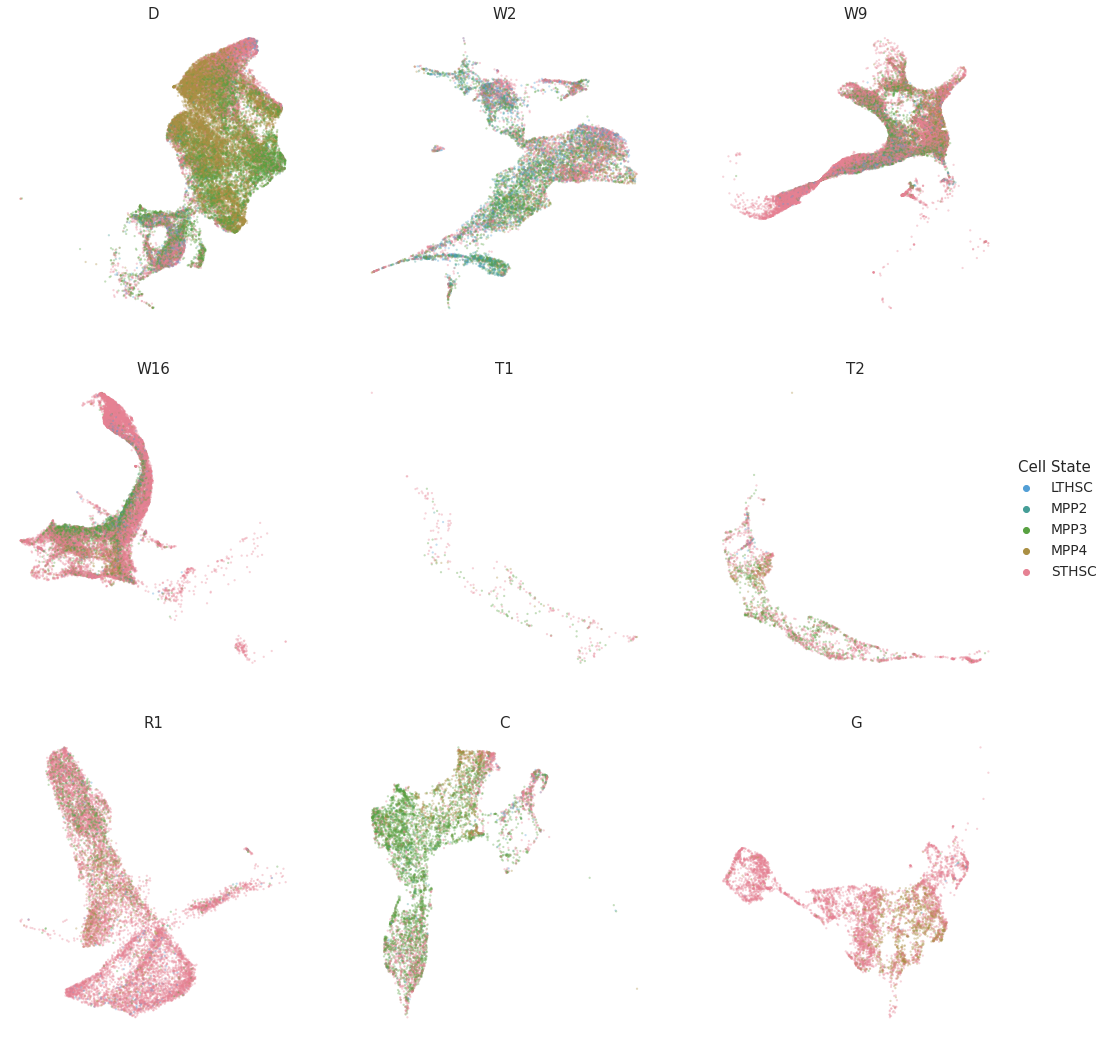

In [560]:
mpp_pal = pd.Series(sns.color_palette('husl',
                                      facs_markers_df.FACS_labels.unique().shape[0], 
                                      desat=.75),
                    index=facs_markers_df.FACS_labels.unique()).to_dict()
cell_filter = 'scNym == "hematopoietic precursor cell" & FACS_labels != "Unknown"'
g = sns.relplot(data=facs_markers_df.query(cell_filter).rename(columns={'FACS_labels':'Cell State'}),
                col='Study',
                hue='Cell State',
                hue_order=['LTHSC','MPP2','MPP3','MPP4','STHSC'],
                alpha=.35,
                x='monocle_UMAP1',
                y='monocle_UMAP2',
                s=5,
                edgecolor='none',
                palette=mpp_pal,
                linewidth=0,
                facet_kws={'sharex':False,
                           'sharey':False},
                rasterized=True,
                col_wrap=3)
g.set_titles('{col_name}')
for ax, study in zip(g.fig.axes, g.col_names):
    ax.axis('off')
    #root_cell = mouse_adata.obs.loc[mouse_adata.obs.query('Study == @study')['monocle_ps'].idxmin()]
    #ax.scatter(root_cell.monocle_UMAP1,root_cell.monocle_UMAP2, c='k',s=20)


g.savefig('/home/bharris/pseudotime/figures/mpp_clusters/mpp_cluster_asignments.pdf',transparent=True)

## MetaNeighbor US

In [567]:
mouse_hsc = mouse_adata[mouse_adata.obs.scNym=='hematopoietic precursor cell']
mouse_hsc.obs.study_id = mouse_hsc.obs.study_id.astype(str)
mouse_hsc.obs['FACS_labels'] = facs_markers_df.loc[mouse_hsc.obs_names,'FACS_labels'].astype(str)
mouse_hsc = mouse_hsc[mouse_hsc.obs.FACS_labels!='Unknown']
pymn.variableGenes(mouse_hsc,'study_id')
mnus_res = pymn.MetaNeighborUS(mouse_hsc,
                    'Study',
                    'FACS_labels',
                    fast_version=True,
                   save_uns=False)
mnus_res_no_STHSC = pymn.MetaNeighborUS(mouse_hsc[mouse_hsc.obs.FACS_labels!='STHSC'],
                    'Study',
                    'FACS_labels',
                    fast_version=True,
                   save_uns=False)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.var` of view, copying.


/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/seaborn/matrix.py:1215: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


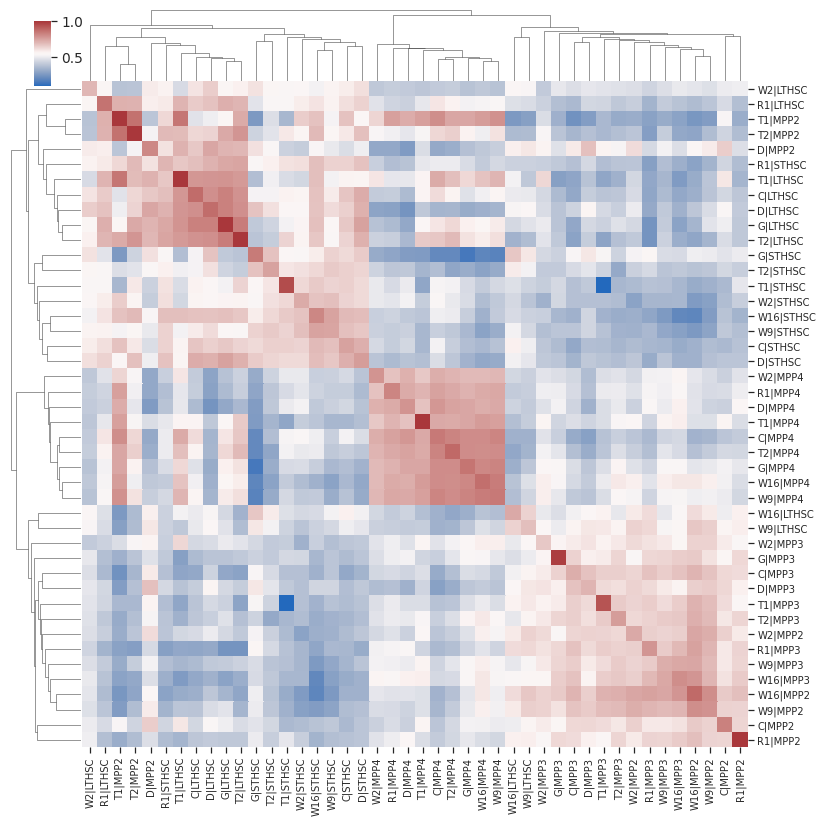

In [1094]:
g = pymn.plotMetaNeighborUS(mnus_res, 
                        figsize=(12,12),
                        xticklabels=True,
                        yticklabels=True,
                        cmap='vlag',
                       cbar_pos=(.05,.89,.02,.075),
                       fontsize=10,
                      dendrogram_ratio=.1,
                       show=False)
g.savefig('/home/bharris/pseudotime/figures/mpp_clusters/mnus_res.pdf',transparent=True)

In [27]:
go_mouse = pd.read_hdf('/home/bharris/GO_data/go_mouse_nw.hdf5', 'go')

go_annots = pd.read_csv('/home/bharris/GO_data/go_annotation_descriptions.csv',
                        index_col='X')
go_annots.columns = ['idx', 'description', 'category']
go_annots.index.name = 'GO Term'
go_annots.drop(columns='idx', inplace=True)
go_annots.head()

,description,category
GO Term,,
GO:0000001,mitochondrion inheritance,biological_process
GO:0000002,mitochondrial genome maintenance,biological_process
GO:0000003,reproduction,biological_process
GO:0000005,obsolete ribosomal chaperone activity,molecular_function
GO:0000006,high-affinity zinc transmembrane transporter a...,molecular_function


In [34]:
go_used  = go_mouse.reindex(mouse_hsc.var_names).fillna(0)
go_sizes = go_used.sum()
go_used  = go_used.loc[:,(go_sizes >= 10) & (go_sizes <= 100)]

In [1225]:
np.savetxt('go_terms_used.csv',go_used.columns.values)

Index(['GO:0000002', 'GO:0000014', 'GO:0000018', 'GO:0000027', 'GO:0000028',
       'GO:0000030', 'GO:0000038', 'GO:0000041', 'GO:0000045', 'GO:0000049',
       ...
       'GO:2001237', 'GO:2001238', 'GO:2001239', 'GO:2001240', 'GO:2001241',
       'GO:2001243', 'GO:2001244', 'GO:2001251', 'GO:2001258', 'GO:2001259'],
      dtype='object', name='go_id', length=5516)

In [41]:
mouse_hsc.obs.FACS_labels = mouse_hsc.obs.FACS_labels.astype(str)

In [1254]:
go_used.to_csv('/tyrone-data/bharris/for_john/go_used.csv')

## MetaNeighbor GO

In [368]:
%%time
mkl.set_num_threads(10)
mn_res = pymn.MetaNeighbor(mouse_hsc[mouse_hsc.obs.FACS_labels!='Unknown'],
                  'study_id',
                  'FACS_labels',
                  go_used, 
                  fast_hi_mem=True, 
                  fast_version=True,
                  save_uns=False)

CPU times: user 12h 12min 28s, sys: 46min 36s, total: 12h 59min 4s
Wall time: 1h 40min 7s


In [1274]:
mn_res.to_csv('/tyrone-data/bharris/for_john/cell_state_GO_enrichment.csv')

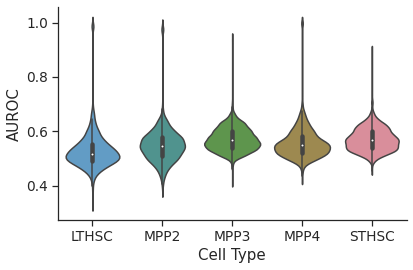

In [268]:
sns.violinplot(data=mn_res.reset_index().melt(id_vars='Cell Type',value_name='AUROC'),
               x='Cell Type',
               y='AUROC', 
               palette=mpp_pal)
plt.tight_layout()
plt.savefig('/home/bharris/pseudotime/figures/mpp_clusters/mn_violinplot.pdf',
            transparent=True)

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


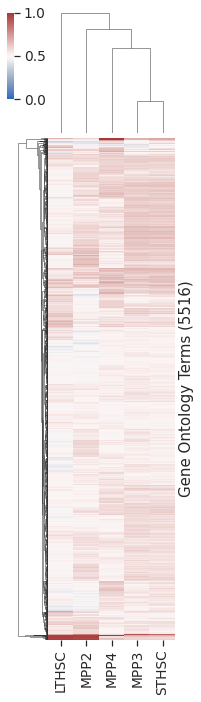

In [510]:
cg = sns.clustermap(mn_res.T,
                    cmap='vlag',
                    vmin=0,
                    vmax=1,
                   cbar_pos=(0.025, .85, 0.025, 0.12),
                   figsize=(4,10))
cg.ax_heatmap.set_yticks([])
cg.ax_heatmap.set(ylabel=f'Gene Ontology Terms ({mn_res.shape[1]})')
cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xticklabels(),rotation=90)
cg.savefig('/home/bharris/pseudotime/figures/mpp_clusters/top_HSC_metaneighbor_all_terms.pdf',
           transparent=True)

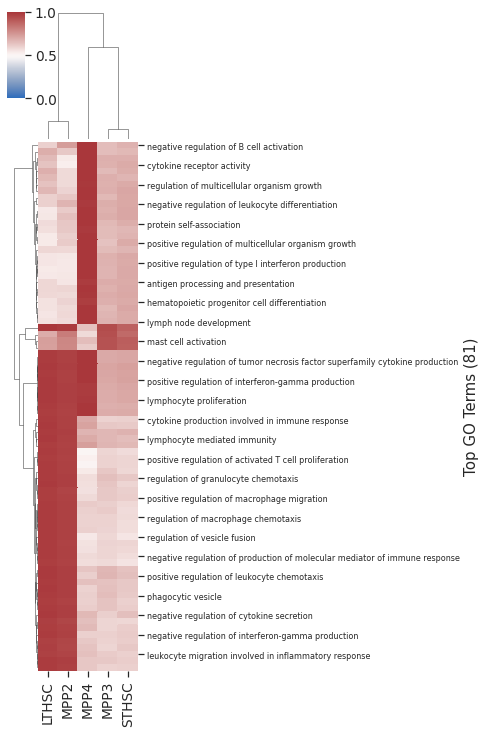

In [531]:
top_mn_res = mn_res.loc[:,(mn_res>.9).any(axis=0)].T
annots_dict = go_annots.loc[top_mn_res.index,'description']
top_mn_res.index = annots_dict
cg = sns.clustermap(top_mn_res, 
                    cmap='vlag',
                    vmin=0, 
                    vmax=1,
                    cbar_pos=(0.015, .85, 0.025, 0.12))
cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xticklabels(),rotation=90)
cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_yticklabels(),fontsize=8)
cg.ax_heatmap.set(ylabel=f'Top GO Terms ({top_mn_res.shape[0]})')
cg.savefig('/home/bharris/pseudotime/figures/mpp_clusters/top_HSC_metaneighbor_top_terms.pdf',
           transparent=True)

In [1253]:
top_mn_res.loc['lymphocyte proliferation']

LTHSC    0.988626
MPP2     0.978658
MPP3     0.697646
MPP4     0.988502
STHSC    0.708569
Name: lymphocyte proliferation, dtype: float64

In [785]:
mpp3_term = annots_dict.index[annots_dict=='mast cell activation'][0]

mpp4_term = annots_dict.index[annots_dict=='lymphocyte proliferation'][0]
mpp4_term2 = annots_dict.index[annots_dict=='positive regulation of interferon-gamma production'][0]

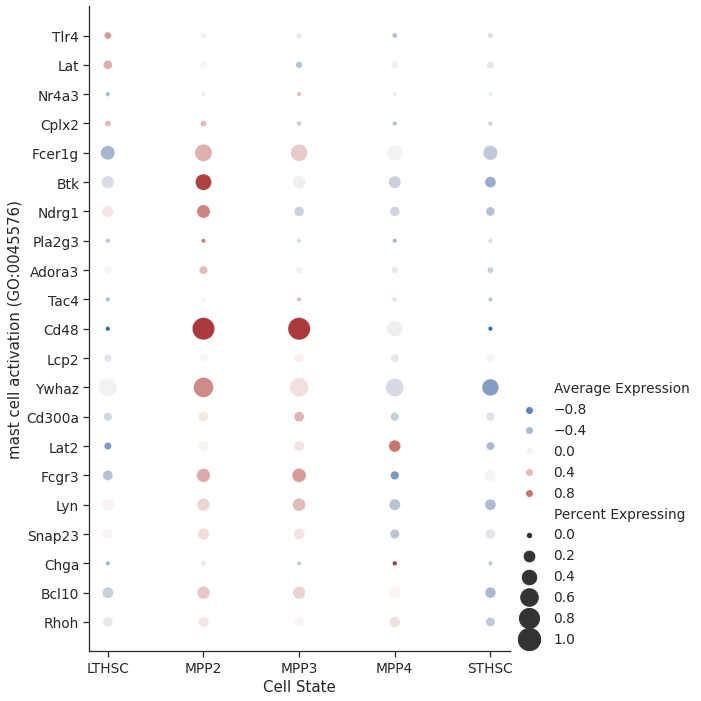

In [801]:
mouse_hsc.obs.study_id = mouse_hsc.obs.study_id.astype(str)
mouse_hsc.obs.FACS_labels = mouse_hsc.obs.FACS_labels.astype(str)

fig, ax = plt.subplots(figsize=(10,10))
ax = plotDotPlot(mouse_hsc[mouse_hsc.obs.FACS_labels!='Unknown'],
                 go_used[mpp3_term],
                 study_col='study_id',
                 ct_col='FACS_labels',
                 normalize_library_size=False,
                 average_expressing_only=False,
                 ax=ax,
                show=False,
                 sizes=(20,500))
ax.set(xlabel='Cell State',ylabel=f'{go_annots.loc[mpp3_term,"description"]} ({mpp3_term})')
labels_order_mpp3 = [a.get_text() for a in ax.get_yticklabels()]
plt.tight_layout()
plt.savefig(f'/home/bharris/pseudotime/figures/mpp_clusters/dotplot_{mpp3_term}.pdf',
            transparent=True)

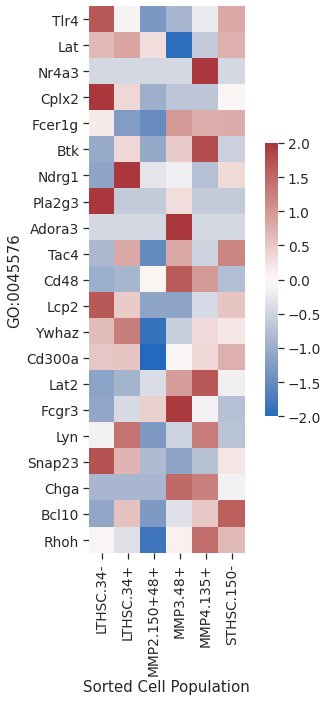

In [803]:
fig, ax = plt.subplots(figsize=(6,10))
bulk_expr_plot = (bulk_expr_bm_avg
                  .reindex(labels_order_mpp3[::-1])
                  .dropna()
                  .T
                  .apply(stats.zscore)
                  .T)
bulk_expr_plot.columns = bulk_expr_plot.columns.str.extract('(.*).BM')[0].values
sns.heatmap(bulk_expr_plot,
            cmap='vlag',
            vmin=-2,
            square=True,
            vmax=2,
            cbar_kws={'shrink':.5})
ax.set(facecolor='.7',
       xlabel='Sorted Cell Population',
       ylabel=mpp3_term)
plt.tight_layout()
plt.show()

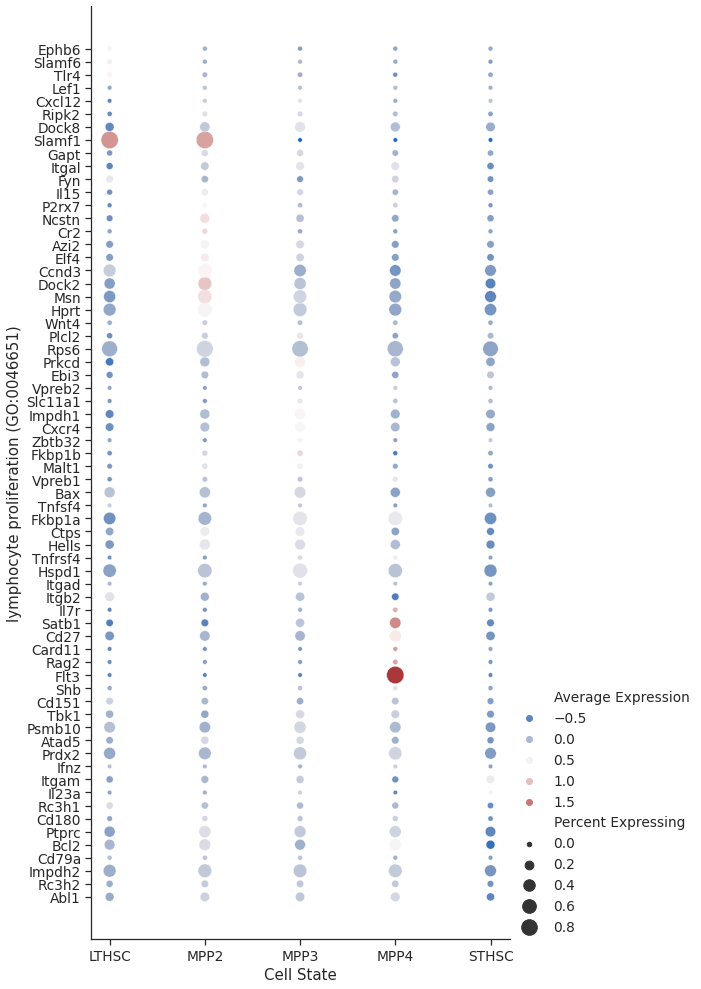

In [804]:
mouse_hsc.obs.study_id = mouse_hsc.obs.study_id.astype(str)
mouse_hsc.obs.FACS_labels = mouse_hsc.obs.FACS_labels.astype(str)

fig, ax = plt.subplots(figsize=(10,14))
ax = plotDotPlot(mouse_hsc[mouse_hsc.obs.FACS_labels!='Unknown'],
                 go_used[mpp4_term],
                 study_col='study_id',
                 ct_col='FACS_labels',
                 normalize_library_size=False,
                 average_expressing_only=False,
                 ax=ax,
                show=False,
                 sizes=(20,300))
ax.set(xlabel='Cell State',ylabel=f'{go_annots.loc[mpp4_term,"description"]} ({mpp4_term})')
labels_order_mpp4 = [a.get_text() for a in ax.get_yticklabels()]
plt.tight_layout()
plt.savefig(f'/home/bharris/pseudotime/figures/mpp_clusters/dotplot_{mpp4_term}.pdf',
            transparent=True)

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


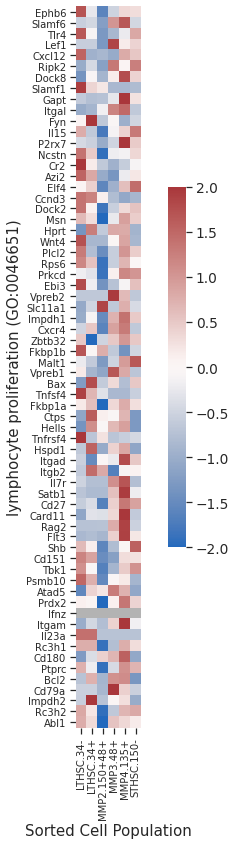

In [817]:
fig, ax = plt.subplots(figsize=(8,12))

bulk_expr_plot = bulk_expr_bm_avg.reindex(labels_order_mpp4[::-1]).dropna().T.apply(stats.zscore).T
bulk_expr_plot.columns = bulk_expr_plot.columns.str.extract('(.*).BM')[0].values
sns.heatmap(bulk_expr_plot,
            cmap='vlag',
            vmin=-2,
            square=True,
            vmax=2,
            yticklabels=True,
            cbar_kws={'shrink':.5})
ax.set(facecolor='.7',
       xlabel='Sorted Cell Population',
       ylabel=f'{go_annots.loc[mpp4_term,"description"]} ({mpp4_term})')
ax.set_xticklabels(ax.get_xticklabels(),fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=10)
plt.tight_layout()
plt.show()

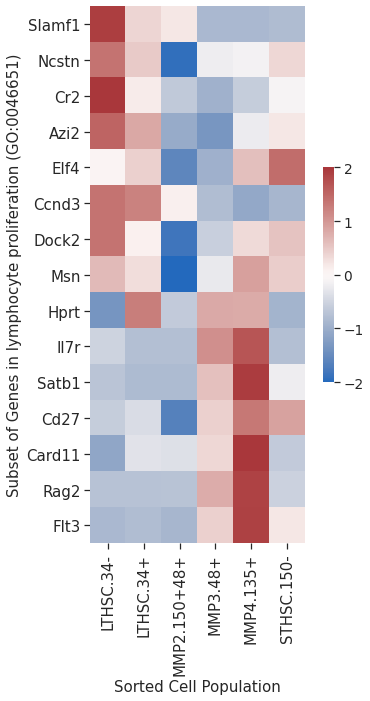

In [830]:
mpp4_term_subset = ['Slamf1',
                    'Ncstn',
                    'Cr2',
                    'Azi2',
                    'Elf4',
                    'Ccnd3',
                    'Dock2',
                    'Msn',
                    'Hprt',
                    'Il7r',
                    'Satb1',
                    'Cd27',
                    'Card11',
                    'Rag2',
                    'Flt3']
fig, ax = plt.subplots(figsize=(6,10))

bulk_expr_plot = bulk_expr_bm_avg.reindex(mpp4_term_subset).dropna().T.apply(stats.zscore).T
bulk_expr_plot.columns = bulk_expr_plot.columns.str.extract('(.*).BM')[0].values
sns.heatmap(bulk_expr_plot,
            cmap='vlag',
            vmin=-2,
            square=True,
            vmax=2,
            yticklabels=True,
            cbar_kws={'shrink':.4})
ax.set(facecolor='.7',
       xlabel='Sorted Cell Population',
       ylabel=f'Subset of Genes in {go_annots.loc[mpp4_term,"description"]} ({mpp4_term})')
ax.set_xticklabels(ax.get_xticklabels(),fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=15)
plt.tight_layout()
plt.savefig(f'/home/bharris/pseudotime/figures/mpp_clusters/bulk_{mpp4_term}_heatmap_subset.pdf',
           transparent=True)

In [204]:
top_mn_res.to_csv('/home/bharris/pseudotime/figures/mpp_clusters/top_HSC_metaneighbor_results.csv')

In [1281]:
supp = mn_res.T.copy()

In [1284]:
supp.insert(0,'Description',go_annots.reindex(supp.index)['description'])

In [1287]:
supp.dropna().to_csv('/home/bharris/pseudotime/supplementary_tables/supplementary_table_3.csv.gz')

## Markers

In [269]:
##Saving loom file to create markers from MetaMarkers

mouse_hsc.write_loom('/home/bharris/pseudotime/data/droplet_expression/mouse_hsc_labeled.loom',
                     write_obsm_varm=False)

The loom file will lack these fields:
{'X_scnym', 'X_umap'}
Use write_obsm_varm=True to export multi-dimensional annotations


In [529]:
facs_markers = pd.read_csv('/home/bharris/pseudotime/data/markers/droplet_FACS_labels_metamarkers.csv.gz',skiprows=1)
facs_markers['log2FC'] = np.log2(facs_markers.fold_change)

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [1277]:
!cp /home/bharris/pseudotime/data/markers/droplet_FACS_labels_metamarkers.csv.gz /tyrone-data/bharris/for_john/

In [1278]:
!ls /tyrone-data/bharris/for_john/

cell_state_GO_enrichment.csv
cluster_GO_enrichment.csv
droplet_FACS_labels_metamarkers.csv.gz
droplet_scNym_metamarkers.csv.gz
erythroid_and_monocyte_lineage_adata_no_gaps.h5ad
erythroid_and_monocyte_lineage_adata_no_gaps.loom
go_used.csv
mouse_hsc_labeled.h5ad
mouse_hsc_labeled.loom


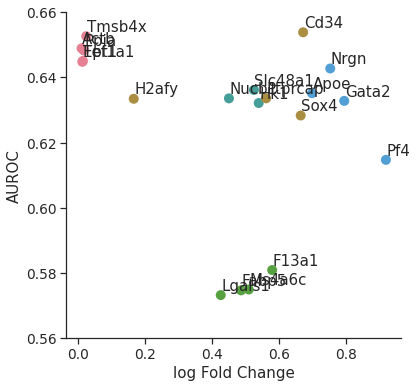

In [667]:
fig, ax = plt.subplots(figsize=(6,6))
top_markers = (facs_markers
                           .query('rank<=5')
                           .set_index('gene')
                           .drop(['Slamf1','Flt3','Cd48'])
                           .rename(columns={'cell_type':'Cell State'}))
sns.scatterplot(data=top_markers,
               x='log2FC',
                y='auroc',
                hue='Cell State',
                palette=mpp_pal,
                edgecolor='none',
                s=100,
                ax=ax,
               legend=False)
offset = .0015
for row in top_markers.itertuples():
    ax.text(row.log2FC+offset, row.auroc+offset, row.Index)
#ax.legend(loc=(.8,0),frameon=False, title='Cell State')
ax.set(xlabel='log Fold Change',ylabel='AUROC')
ax.set_yticks(ax.get_yticks()[::2])
plt.savefig('/home/bharris/pseudotime/figures/mpp_clusters/marker_scatter.pdf',
           transparent=True)

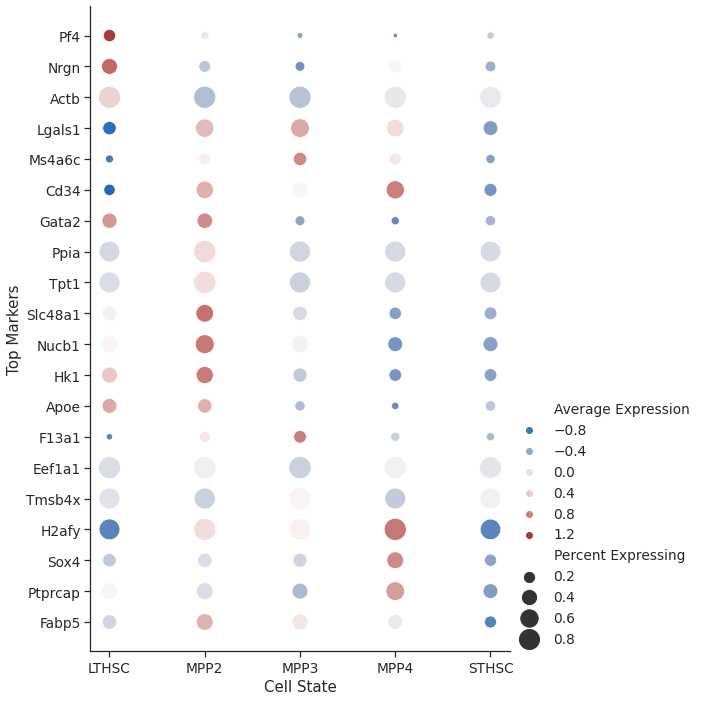

In [875]:
mouse_hsc.obs.study_id = mouse_hsc.obs.study_id.astype(str)
mouse_hsc.obs.FACS_labels = mouse_hsc.obs.FACS_labels.astype(str)

selected_genes = (facs_markers
                           .query('rank<=5')
                           .set_index('gene')
                           .drop(['Slamf1','Flt3','Cd48'])
                           .index
                           .unique())
fig, ax = plt.subplots(figsize=(10,10))
ax = plotDotPlot(mouse_hsc[mouse_hsc.obs.FACS_labels!='Unknown'],
                 pd.Series(np.in1d(mouse_hsc.var_names,selected_genes),
                           index=mouse_hsc.var_names),
                 study_col='study_id',
                 ct_col='FACS_labels',
                 normalize_library_size=False,
                 average_expressing_only=False,
                 ax=ax,
                show=False,
                 sizes=(20,500))
ax.set(xlabel='Cell State',ylabel='Top Markers')
labels_order = [a.get_text() for a in ax.get_yticklabels()]
plt.tight_layout()
plt.savefig('/home/bharris/pseudotime/figures/mpp_clusters/top_markers_dotplot.pdf',transparent=True)

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


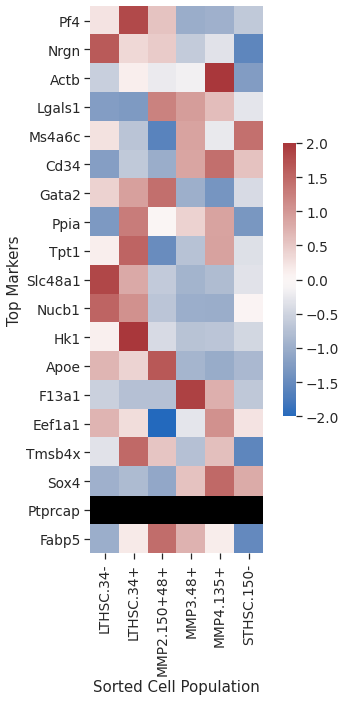

In [1119]:
fig, ax = plt.subplots(figsize=(6,10))
bulk_expr_plot_markers = bulk_expr_bm_avg.reindex(labels_order[::-1]).dropna().T.apply(stats.zscore).T
bulk_expr_plot_markers.columns = bulk_expr_plot_markers.columns.str.extract('(.*).BM')[0].values
sns.heatmap(bulk_expr_plot_markers.isna(),cbar=False,cmap='Greys',ax=ax)
sns.heatmap(bulk_expr_plot_markers,
            cmap='vlag',
            vmin=-2,
            square=True,
            vmax=2,
            cbar_kws={'shrink':.5},
            mask=bulk_expr_plot_markers.isna(),
            ax=ax)

ax.set(xlabel='Sorted Cell Population',
       ylabel='Top Markers')
plt.tight_layout()
#ax.set_xticklabels(ax.get_xticklabels(),ha='right',rotation=30,fontsize=12)
plt.savefig('/home/bharris/pseudotime/figures/mpp_clusters/bulk_marker_heatmap.pdf',
            transparent=True)

In [879]:
marker_dp_data = getDotPlotData(mouse_hsc[mouse_hsc.obs.FACS_labels!='Unknown'],
                 pd.Series(np.in1d(mouse_hsc.var_names,selected_genes),
                           index=mouse_hsc.var_names),
                 study_col='study_id',
                 ct_col='FACS_labels',
                 normalize_library_size=False,
                 average_expressing_only=False)


scDotPlot_data = marker_dp_data.pivot(index='Gene',columns='Cell Type',values='Average Expression')


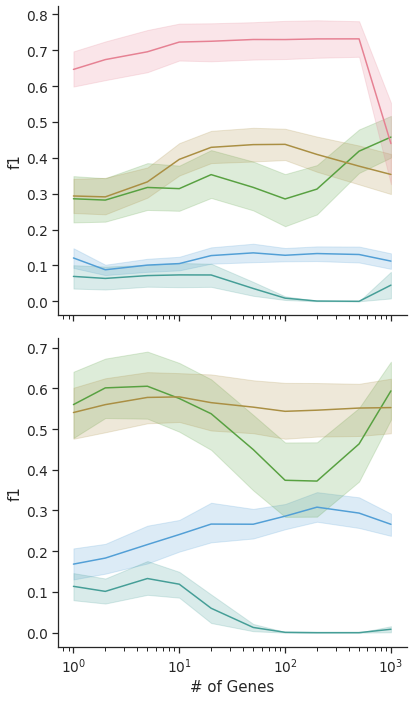

In [1246]:
fig, ax= plt.subplots(figsize=(6,10),nrows=2,sharex=True)
tmp=pd.read_csv('/home/bharris/pseudotime/data/markers/drop_FACS_labels_all_F1_scores.csv')
sns.lineplot(data=tmp.groupby(['test_dataset','true_label','n_genes'])['f1'].max().reset_index().fillna(0),
             x='n_genes',
             y='f1',
             hue='true_label',
             palette=mpp_pal,
             legend=False,
             ci=68,
            ax=ax[0])
# ax.set_xticks([1,10,100,1000])
# ax.set(xscale='log',xlabel='# of Genes')

tmp=pd.read_csv('/home/bharris/pseudotime/data/markers/drop_FACS_labels_all_F1_scores_no_STHSC.csv')
sns.lineplot(data=tmp.groupby(['test_dataset','true_label','n_genes'])['f1'].max().reset_index().fillna(0),
             x='n_genes',
             y='f1',
             hue='true_label',
             palette=mpp_pal,
             legend=False,
             ci=68,
            ax=ax[1])
ax[1].set_xticks([1,10,100,1000])
ax[1].set(xscale='log',xlabel='# of Genes')
plt.tight_layout()
plt.savefig('/home/bharris/pseudotime/figures/mpp_clusters/markers_loocv_F1.pdf',transparent=True)

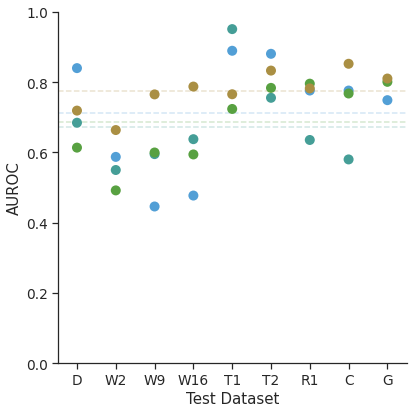

In [1219]:
marker_perf = pd.read_csv('/home/bharris/pseudotime/data/markers/drop_FACS_AUROC_no_STHSC.csv').melt(id_vars='Cell.State',
                                                                                       var_name='Test Dataset',
                                                                                       value_name='AUROC')
fig, ax= plt.subplots(figsize=(6,6))
sns.stripplot(data=marker_perf,
              x='Test Dataset',
              y='AUROC',
              hue='Cell.State',
              palette=mpp_pal,
             size=10,
             ax=ax,
             jitter=False)
ax.get_legend().remove()
for row in marker_perf.groupby('Cell.State').mean().itertuples():
    ax.axhline(row.AUROC,c=mpp_pal[row.Index],ls='--',alpha=.25)
ax.set(ylim=[0,1])
plt.tight_layout()
plt.savefig('/home/bharris/pseudotime/figures/mpp_clusters/markers_loocv_aurocs.pdf',transparent=True)